This notebook demonstrates how to fine‑tune the DreaMS model for a binary classification task (detecting chlorine in molecules) using the MassSpecGym dataset. We’ll:

1. **Annotate** the MassSpecGym MGF with chlorine labels.
2. **Prepare** a `ChlorineDetectionDataset` and a `BenchmarkDataModule`.
3. **Train** a baseline MLP classifier.
4. **Fine‑tune** the DreaMS encoder with a classification head (`LitDreamsClassifier`).
5. **Evaluate** on the test split and **save** the checkpoint.

All paths are defined relative to `PROJECT_ROOT` for reproducibility.

In [1]:
import sys
from pathlib import Path

# assume this notebook lives in notebooks/, so parent() is the repo root
sys.path.append(str(Path().resolve().parent))
from paths import PROJECT_ROOT

from benchmark.utils.data import annotate_mgf_with_label

import torch
import pytorch_lightning as pl

from massspecgym.data.transforms import SpecTokenizer
# from benchmark.data.datasets import ChlorineDetectionDataset
from benchmark.data.datasets import BinaryDetectionDataset
from benchmark.data.data_module import BenchmarkDataModule

from benchmark.models.lit_dreams_module import LitDreamsClassifier
from benchmark.models.lit_binary_classifier import LitBinaryClassifier



/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/__init__.py:41: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


### Comp resources setting

In [2]:
import torch
from pytorch_lightning import Trainer

def get_trainer_kwargs():
    """
    Inspect available hardware and return a dict suitable
    for passing into Trainer(..., **kwargs).
    """
    if torch.cuda.is_available():
        # one or more NVIDIA GPUs
        return {
            "accelerator": "gpu",
            "devices": torch.cuda.device_count(),
            "precision": 16,           # use mixed-precision for speed
        }
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        # Apple Silicon GPU via MPS
        return {
            "accelerator": "mps",
            "devices": 1,
            "precision": 16,           # mixed-precision works on MPS
        }
    else:
        # fallback to CPU
        return {
            "accelerator": "cpu",
            "devices": 1,
        }

In [3]:
# Paths
DATA_DIR   = PROJECT_ROOT / "data" / "massspecgym"
ORIG_MGF   = DATA_DIR / "MassSpecGym.mgf"
LABELED_MGF = DATA_DIR / "MassSpecGym_chlorine.mgf"

MODEL_PATH = PROJECT_ROOT / "data" / "model_checkpoints" / "ssl_model.ckpt"

#### Here we define function for annotation of our data. It is important as it will set ground truth for our data. Here we are working with MassSpecGym data where each mass spectra is annotated with correct molecule and based on this we can further annotate our spectra.

#### therefore here is are solving chlorine detection problem, we pull molecule associated with mass spectra and ask if molecule contains Chlorine, if yes we assign mass spectra label with value 1.0, respectively 0.0 if it does not contain Chlorine,

In [3]:
# # Define labeling function: 1.0 if 'Cl' in FORMULA
# label_fn = lambda md: float("Cl" in md.get("FORMULA", ""))

In [4]:
# # Write out labeled MGF
# annotate_mgf_with_label(ORIG_MGF, LABELED_MGF, label_fn)
# print(f"Labeled MGF written to: {LABELED_MGF}")

In [3]:
# 2) Annotate (skips if already done)
BinaryDetectionDataset.annotate_mgf(
    input_pth  = ORIG_MGF,
    output_pth = LABELED_MGF,
    label_fn   = lambda md: float("Cl" in md.get("formula", "")),
)

/Users/macbook/CODE/DreaMS_MIMB/data/massspecgym/MassSpecGym_chlorine.mgf already exists; skipping annotation.


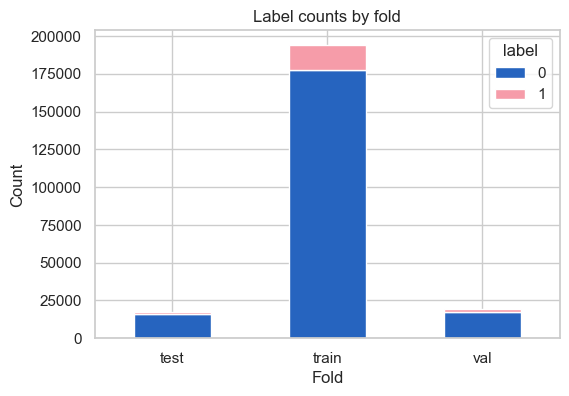

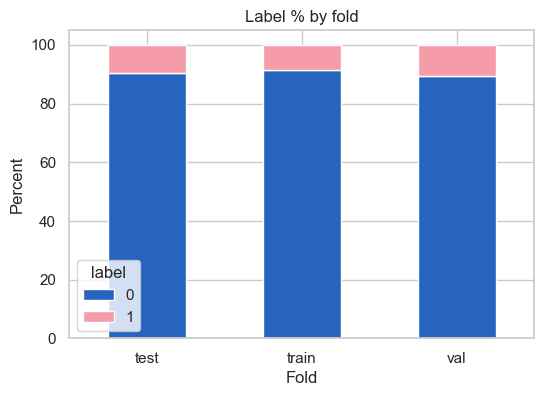

In [4]:
# 3) Inspect fold‐wise distribution
BinaryDetectionDataset.plot_fold_distribution(LABELED_MGF)


=== Example label 0 ===


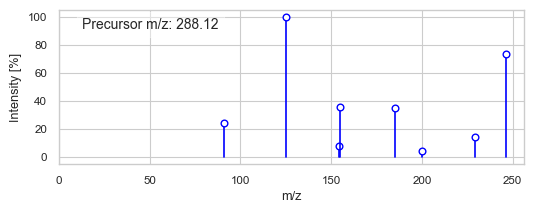

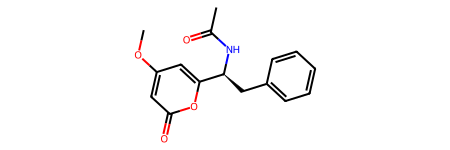

{'identifier': 'MassSpecGymID0000001', 'smiles': 'CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC', 'inchikey': 'VFMQMACUYWGDOJ', 'formula': 'C16H17NO4', 'precursor_formula': 'C16H18NO4', 'parent_mass': '287.115224', 'precursor_mz': 288.1225, 'adduct': '[M+H]+', 'instrument_type': 'Orbitrap', 'collision_energy': '30.0', 'fold': 'train', 'simulation_challenge': 'True', 'label': '0'}

=== Example label 1 ===


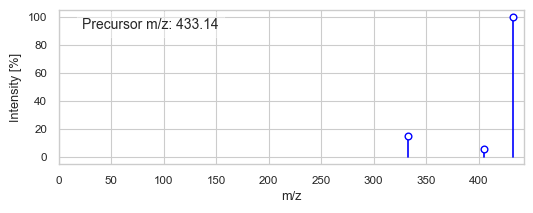

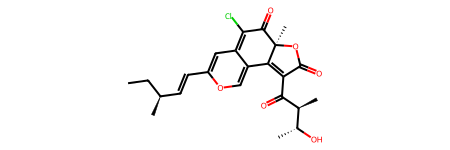

{'identifier': 'MassSpecGymID0000586', 'smiles': 'CC[C@H](C)/C=C/C1=CC2=C(C(=O)[C@@]3(C(=C(C(=O)O3)C(=O)[C@@H](C)[C@@H](C)O)C2=CO1)C)Cl', 'inchikey': 'HWSQVPGTQUYLEQ', 'formula': 'C23H25ClO6', 'precursor_formula': 'C23H26ClO6', 'parent_mass': '432.133424', 'precursor_mz': 433.1407, 'adduct': '[M+H]+', 'instrument_type': 'Orbitrap', 'collision_energy': '10.0', 'fold': 'test', 'simulation_challenge': 'True', 'label': '1'}


In [4]:
# 4) Visualize one negative & one positive example
#    By default looks for 'library_SMILES'; override if your key is 'smiles'
BinaryDetectionDataset.visualize_examples(
    mgf_pth    = LABELED_MGF,
    smiles_key = 'smiles'
)

#### Now as we prepared data, we can provide it to DreaMS and learns it to distinguish if mass spectra contain chlorine.

In [3]:
# 1) Instantiate your Lightning module for imbalanced binary detection
# lit = LitBinaryClassifier(
#     ckpt_path=MODEL_PATH,
#     n_highest_peaks=128,    # must match our tokenizer
#     lr=1e-6,
#     dropout=0.1,
#     train_encoder=True,     # fine-tune the entire encoder
#     pos_weight=None,        # or set to dataset_neg_count / dataset_pos_count
# )

In [4]:
lit = LitBinaryClassifier(
    ckpt_path       = MODEL_PATH,
    n_highest_peaks = 64,
    lr              = 1e-6,      # ← your chosen LR
    dropout         = 0.1,
    train_encoder   = True,
    pos_weight      = None,
)

In [5]:
# 2) Tokenize spectra into fixed-length set representations
spec_transform = SpecTokenizer(n_peaks=64)

#### Here we actually load benchmark and data that will go into model, and will be trained on

In [6]:
# ds_dreams = ChlorineDetectionDataset(
#     pth=LABELED_MGF,
#     spec_transform=spec_transform,
#     dtype=torch.float32
# )

ds_dreams = BinaryDetectionDataset(
    pth=LABELED_MGF,
    spec_transform=spec_transform,
)

In [7]:
# 3) Prepare the DataModule
dm_dreams = BenchmarkDataModule(
    dataset    = ds_dreams,
    batch_size = 64,
    num_workers= 0
)
dm_dreams.setup()

In [8]:
# Inspect one batch just to sanity-check shapes:
batch = next(iter(dm_dreams.train_dataloader()))
print("spec shape:", batch["spec"].shape)    # -> [B, 61, 2]
print("label shape:", batch["label"].shape)

spec shape: torch.Size([64, 65, 2])
label shape: torch.Size([64])


### Now we are approaching training, meaning model will se annotated examples and will learn to recognize if mass spectra contain chlorine 

#### Can take some time, however, once the DreaMS is trained, you do not need to redo all these steps, but just load already learned DreaMS

# TODO add condition if GPU available

In [36]:
# trainer = pl.Trainer(
#     max_epochs=5,
#     accelerator="cpu",  # or "gpu"
#     devices=1,
#     log_every_n_steps=10,
# )

### TMP

In [9]:
from pytorch_lightning.callbacks import Callback
import torch

class MetricsLogger(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses   = []
        self.val_aucs     = []
        self.val_prs      = []
        self.val_f1s      = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        loss = (
            outputs.detach().cpu().item()
            if isinstance(outputs, torch.Tensor)
            else outputs['loss'].detach().cpu().item()
        )
        self.train_losses.append(loss)

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
        m = trainer.callback_metrics
        # note: callback_metrics keys are strings exactly as you logged them
        if 'val_loss' in m:
            self.val_losses.append(m['val_loss'].cpu().item())
        if 'val_auc' in m:
            self.val_aucs.append(m['val_auc'].cpu().item())
        if 'val_pr' in m:
            self.val_prs.append(m['val_pr'].cpu().item())
        if 'val_f1' in m:
            self.val_f1s.append(m['val_f1'].cpu().item())

In [10]:
metrics_cb = MetricsLogger()
trainer_kwargs = get_trainer_kwargs()

trainer = pl.Trainer(
    max_epochs=3,
    # limit_train_batches=50,
    # limit_val_batches=20,       # run only 3 validation batches
    # limit_test_batches=20,      # run only 3 test batches
    callbacks=[metrics_cb],
    **trainer_kwargs
)


/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logg

In [11]:
trainer.fit(lit, datamodule=dm_dreams)

Loading `train_dataloader` to estimate number of stepping batches.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.

  | Name          | Type                   | Params
---------------------------------------------------------
0 | model         | DreamsClassifier       | 95.6 M
1 | train_bal_acc | BinaryAccuracy         | 0     
2 | val_bal_acc   | BinaryAccuracy         | 0     
3 | val_auc       | BinaryAUROC            | 0     
4 | val_pr        | BinaryAveragePrecision | 0     
5 | val_f1        | BinaryF1Score          | 0     
---------------------------------------------------------
95.6 M    Trainable params
0         Non-trainable params
95.6 M    Total params
382.202   Total estimated model p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true po

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 37. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


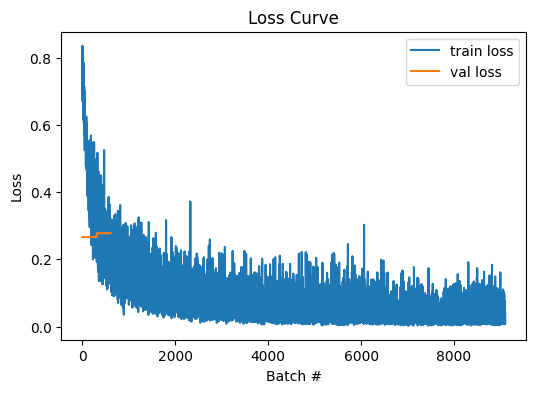

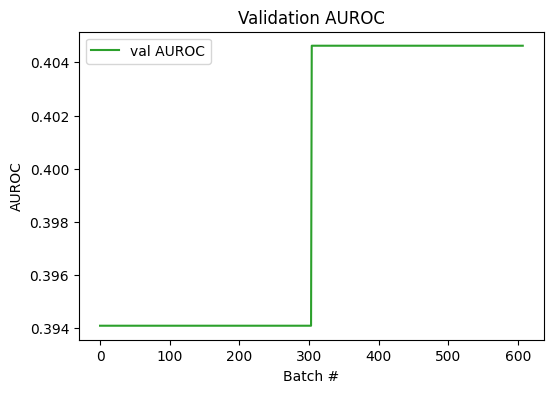

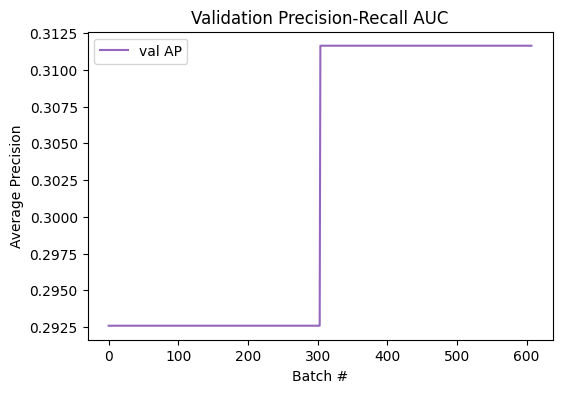

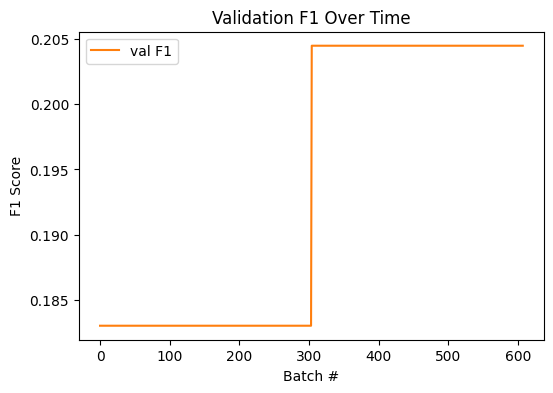

In [12]:
import matplotlib.pyplot as plt

# 1) Loss
plt.figure(figsize=(6,4))
plt.plot(metrics_cb.train_losses, label="train loss")
plt.plot(metrics_cb.val_losses,   label="val loss")
plt.xlabel("Batch #"); plt.ylabel("Loss")
plt.legend(); plt.title("Loss Curve")
plt.show()

# 2) AUC
if metrics_cb.val_aucs:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_cb.val_aucs, label="val AUROC", color='tab:green')
    plt.xlabel("Batch #"); plt.ylabel("AUROC")
    plt.legend(); plt.title("Validation AUROC")
    plt.show()

# 3) Average Precision
if metrics_cb.val_prs:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_cb.val_prs, label="val AP", color='tab:purple')
    plt.xlabel("Batch #"); plt.ylabel("Average Precision")
    plt.legend(); plt.title("Validation Precision-Recall AUC")
    plt.show()

# 4) F1 Score
if metrics_cb.val_f1s:
    plt.figure(figsize=(6,4))
    plt.plot(metrics_cb.val_f1s, label="val F1", color='tab:orange')
    plt.xlabel("Batch #"); plt.ylabel("F1 Score")
    plt.legend(); plt.title("Validation F1 Over Time")
    plt.show()

In [9]:
trainer = pl.Trainer(
    max_epochs=1,
    limit_train_batches=5,     # run only 5 training batches
    limit_val_batches=3,       # run only 3 validation batches
    limit_test_batches=3,      # run only 3 test batches
    accelerator="cpu",         # or "gpu"
    devices=1,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
trainer.fit(lit, datamodule=dm_dreams)


  | Name          | Type                   | Params
---------------------------------------------------------
0 | model         | DreamsClassifier       | 95.6 M
1 | train_bal_acc | BinaryAccuracy         | 0     
2 | val_bal_acc   | BinaryAccuracy         | 0     
3 | val_auc       | BinaryAUROC            | 0     
4 | val_pr        | BinaryAveragePrecision | 0     
5 | val_f1        | BinaryF1Score          | 0     
---------------------------------------------------------
95.6 M    Trainable params
0         Non-trainable params
95.6 M    Total params
382.202   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32


/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028


  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32


/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32
  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32
  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32
  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32
  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32


Validation: |          | 0/? [00:00<?, ?it/s]

  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32
  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32
  ► input x.dtype: torch.float32,   encoder weight dtype: torch.float32


`Trainer.fit` stopped: `max_epochs=1` reached.


In [14]:
trainer.test(lit, datamodule=dm_dreams)

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)  # noqa: B028
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 20. To avoid

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_auc            0.4806259572505951
       val_bal_acc          0.9097175002098083
         val_f1             0.2625061571598053
        val_loss            0.26231491565704346
         val_pr             0.3553357422351837
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.26231491565704346,
  'val_bal_acc': 0.9097175002098083,
  'val_auc': 0.4806259572505951,
  'val_pr': 0.3553357422351837,
  'val_f1': 0.2625061571598053}]

#### Now model was sucessfuly trained and we do not want to repeat computationally expensive training, so we save learned model and will reuse it 

In [13]:
# 4) Save your fine-tuned checkpoint
trainer.save_checkpoint("dreams_chlorine_finetuned.ckpt")

### 4 – Reload & verify

In [18]:
lit2 = LitDreamsClassifier.load_from_checkpoint("dreams_chlorine_finetuned.ckpt")
lit2.eval()
test_trainer = pl.Trainer(accelerator="cpu", devices=1)
test_results = test_trainer.test(lit2, datamodule=dm_dreams)
print(test_results)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/macbook/UTILS/anaconda3/envs/dreams_mimb/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    1.0
        test_loss          5.959106275099657e-08
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 5.959106275099657e-08, 'test_acc': 1.0}]
